In [1]:
# Import relevant libraries.
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import datetime

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('words')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package punkt to C:\Users\Victor
[nltk_data]     K\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Victor
[nltk_data]     K\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to C:\Users\Victor
[nltk_data]     K\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Victor
[nltk_data]     K\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
# Load dataset. Change directory as required.
df = pd.read_csv('all_speeches.csv')
df['len'] = df['text'].str.len()
df.head()

,reference,country,date,title,author,is_gov,text,len
0,r901128a_BOA,australia,1990-11-28,A Proper Role for Monetary Policy,fraser,0,They would no doubt argue that to have two obj...,21288
1,r911003a_BOA,australia,1991-10-03,,fraser,0,Today I wish to talk about real interest rates...,18838
2,r920314a_BOA,australia,1992-03-14,,fraser,0,I welcome this opportunity to talk about prosp...,21100
3,r920529a_BOA,australia,1992-05-29,,fraser,0,It is a pleasure to have this opportunity to a...,23608
4,r920817a_BOA,australia,1992-08-17,,fraser,0,"As a long-time fan of Don Sanders, I am deligh...",25337


In [3]:
# Converting The date column into a time series
df['date'] = pd.to_datetime(df['date'])


In [4]:
# Convert to lower case and remove punctuation.
df['text'] = df['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['text'] = df['text'].str.replace('[^\w\s]','',regex=True)

In [5]:
# Subset the data to reduce processing time.
df_uk = df[df['is_gov']== 1].sort_values('date').reset_index(drop=True)
df_uk = df_uk[df_uk['country']=='united kingdom'].sort_values('date').reset_index(drop=True)
df_uk

,reference,country,date,title,author,is_gov,text,len
0,r981021a_BOE,united kingdom,1998-10-21,Impact of the recent turbulence in internation...,king,1,few industries have suffered more from volatil...,13678
1,r990517a_BOE,united kingdom,1999-05-17,MPC Two Years On,king,1,present at the creation two years ago when it ...,35858
2,r990827a_BOE,united kingdom,1999-08-27,Challenges for Monetary Policy: New and Old,king,1,the turn of the millennium seems an appropriat...,77081
3,r990909a_BOE,united kingdom,1999-09-09,Reforming the International Financial System: ...,king,1,one of the roles which international financial...,35518
4,r991011a_BOE,united kingdom,1999-10-11,Interest Rates and the UK Economy,king,1,twelve months or so ago interest rates were 7 ...,21325
...,...,...,...,...,...,...,...,...
185,r220210a_BOE,united kingdom,2022-02-10,A resilient financial system,bailey,1,its a pleasure to be here this evening and let...,8752
186,r220523a_BOE,united kingdom,2022-05-23,Opening remarks at OeNB monetary policy panel,bailey,1,this is a time of very large economic shocks a...,2638
187,r220712a_BOE,united kingdom,2022-07-12,"The economic landscape: structural change, glo...",bailey,1,monetary policy must respond to a multitude of...,32705
188,r220719a_BOE,united kingdom,2022-07-19,"Bringing inflation back to the 2% target, no i...",bailey,1,lord mayor it is a great pleasure to be here a...,12120


In [6]:
# List of columns to drop
columns_to_drop = ['reference', 'author', 'is_gov']

# Drop the specified columns
df_uk = df_uk.drop(columns=columns_to_drop, axis=1)
df_uk.head()

,country,date,title,text,len
0,united kingdom,1998-10-21,Impact of the recent turbulence in internation...,few industries have suffered more from volatil...,13678
1,united kingdom,1999-05-17,MPC Two Years On,present at the creation two years ago when it ...,35858
2,united kingdom,1999-08-27,Challenges for Monetary Policy: New and Old,the turn of the millennium seems an appropriat...,77081
3,united kingdom,1999-09-09,Reforming the International Financial System: ...,one of the roles which international financial...,35518
4,united kingdom,1999-10-11,Interest Rates and the UK Economy,twelve months or so ago interest rates were 7 ...,21325


In [7]:
# Load sentiment_labelled_wordlist.xlsx dataset.
wordlist_df = pd.read_excel('sentiment_labelled_wordlist.xlsx')

# View the df DataFrame shape and head.
print("The DataFrame shape:", wordlist_df.shape)
wordlist_df.head()

The DataFrame shape: (3880, 8)


,Word,Negative,Positive,Uncertainty,Litigious,Strong,Weak,Constraining
0,ABANDON,1,0,0,0,0,0,0
1,ABANDONED,1,0,0,0,0,0,0
2,ABANDONING,1,0,0,0,0,0,0
3,ABANDONMENT,1,0,0,0,0,0,0
4,ABANDONMENTS,1,0,0,0,0,0,0


In [8]:
# Changing words to lower case
wordlist_df['Word'] = wordlist_df['Word'].str.lower()
wordlist_df.head()

,Word,Negative,Positive,Uncertainty,Litigious,Strong,Weak,Constraining
0,abandon,1,0,0,0,0,0,0
1,abandoned,1,0,0,0,0,0,0
2,abandoning,1,0,0,0,0,0,0
3,abandonment,1,0,0,0,0,0,0
4,abandonments,1,0,0,0,0,0,0


In [9]:
# Counting the words from the word list in the speech 


def Neg_sentiment(tokens):
    neg_score = wordlist_df[wordlist_df['Word'].isin(tokens)]['Negative'].sum()
    neg_score
    return neg_score

def Pos_sentiment(tokens):
    pos_score = wordlist_df[wordlist_df['Word'].isin(tokens)]['Positive'].sum()
    pos_score
    return pos_score

def Uncer_sentiment(tokens):
    uncer_score = wordlist_df[wordlist_df['Word'].isin(tokens)]['Uncertainty'].sum()
    uncer_score
    return uncer_score

def Lit_sentiment(tokens):
    lit_score = wordlist_df[wordlist_df['Word'].isin(tokens)]['Litigious'].sum()
    lit_score
    return lit_score

def Str_sentiment(tokens):
    str_score = wordlist_df[wordlist_df['Word'].isin(tokens)]['Strong'].sum()
    str_score
    return str_score

def Weak_sentiment(tokens):
    weak_score = wordlist_df[wordlist_df['Word'].isin(tokens)]['Weak'].sum()
    weak_score
    return weak_score

def Cons_sentiment(tokens):
    cons_score = wordlist_df[wordlist_df['Word'].isin(tokens)]['Constraining'].sum()
    cons_score
    return cons_score


In [10]:
# Tokenise the speeches
df_uk['text_tokens'] = df_uk['text'].apply(word_tokenize)

# Remove the stop words from speeches 
def filter_tokens(tokens):
    return [token for token in tokens if token.isalpha() and token not in stop_words]

## Apply the filter.
df_uk['text_tokens_no_stopwords'] = df_uk['text_tokens'].apply(filter_tokens)
df_uk['Word_Count'] = df_uk['text_tokens_no_stopwords'].apply(lambda x: len(x))
# df_uk['len'] = df_uk['text'].str.len()

df_uk.head()

,country,date,title,text,len,text_tokens,text_tokens_no_stopwords,Word_Count
0,united kingdom,1998-10-21,Impact of the recent turbulence in internation...,few industries have suffered more from volatil...,13678,"[few, industries, have, suffered, more, from, ...","[industries, suffered, volatility, british, ec...",1183
1,united kingdom,1999-05-17,MPC Two Years On,present at the creation two years ago when it ...,35858,"[present, at, the, creation, two, years, ago, ...","[present, creation, two, years, ago, announced...",3053
2,united kingdom,1999-08-27,Challenges for Monetary Policy: New and Old,the turn of the millennium seems an appropriat...,77081,"[the, turn, of, the, millennium, seems, an, ap...","[turn, millennium, seems, appropriate, moment,...",6904
3,united kingdom,1999-09-09,Reforming the International Financial System: ...,one of the roles which international financial...,35518,"[one, of, the, roles, which, international, fi...","[one, roles, international, financial, officia...",3094
4,united kingdom,1999-10-11,Interest Rates and the UK Economy,twelve months or so ago interest rates were 7 ...,21325,"[twelve, months, or, so, ago, interest, rates,...","[twelve, months, ago, interest, rates, twelve,...",1858


In [11]:
# Applying the wordlist count

df_uk['Neg_count'] = df_uk['text_tokens'].apply(Neg_sentiment)
df_uk['Pos_count'] = df_uk['text_tokens'].apply(Pos_sentiment)
df_uk['Uncer_count'] = df_uk['text_tokens'].apply(Uncer_sentiment)
df_uk['Lit_count'] = df_uk['text_tokens'].apply(Lit_sentiment)
df_uk['Str_count'] = df_uk['text_tokens'].apply(Str_sentiment)
df_uk['Weak_count'] = df_uk['text_tokens'].apply(Weak_sentiment)
df_uk.head()

,country,date,title,text,len,text_tokens,text_tokens_no_stopwords,Word_Count,Neg_count,Pos_count,Uncer_count,Lit_count,Str_count,Weak_count
0,united kingdom,1998-10-21,Impact of the recent turbulence in internation...,few industries have suffered more from volatil...,13678,"[few, industries, have, suffered, more, from, ...","[industries, suffered, volatility, british, ec...",1183,44,14,27,2,3,11
1,united kingdom,1999-05-17,MPC Two Years On,present at the creation two years ago when it ...,35858,"[present, at, the, creation, two, years, ago, ...","[present, creation, two, years, ago, announced...",3053,65,35,37,9,5,8
2,united kingdom,1999-08-27,Challenges for Monetary Policy: New and Old,the turn of the millennium seems an appropriat...,77081,"[the, turn, of, the, millennium, seems, an, ap...","[turn, millennium, seems, appropriate, moment,...",6904,106,57,60,13,5,17
3,united kingdom,1999-09-09,Reforming the International Financial System: ...,one of the roles which international financial...,35518,"[one, of, the, roles, which, international, fi...","[one, roles, international, financial, officia...",3094,92,35,34,14,6,11
4,united kingdom,1999-10-11,Interest Rates and the UK Economy,twelve months or so ago interest rates were 7 ...,21325,"[twelve, months, or, so, ago, interest, rates,...","[twelve, months, ago, interest, rates, twelve,...",1858,51,29,19,7,6,9


In [13]:
# Simple Pos - Neg compound count 
df_uk['Compound_sentiment'] = round((df_uk['Pos_count']-df_uk['Neg_count']) /df_uk['Word_Count'], 3)
df_uk.head()

,country,date,title,text,len,text_tokens,text_tokens_no_stopwords,Word_Count,Neg_count,Pos_count,Uncer_count,Lit_count,Str_count,Weak_count,Compound_sentiment
0,united kingdom,1998-10-21,Impact of the recent turbulence in internation...,few industries have suffered more from volatil...,13678,"[few, industries, have, suffered, more, from, ...","[industries, suffered, volatility, british, ec...",1183,44,14,27,2,3,11,-0.025
1,united kingdom,1999-05-17,MPC Two Years On,present at the creation two years ago when it ...,35858,"[present, at, the, creation, two, years, ago, ...","[present, creation, two, years, ago, announced...",3053,65,35,37,9,5,8,-0.010
2,united kingdom,1999-08-27,Challenges for Monetary Policy: New and Old,the turn of the millennium seems an appropriat...,77081,"[the, turn, of, the, millennium, seems, an, ap...","[turn, millennium, seems, appropriate, moment,...",6904,106,57,60,13,5,17,-0.007
3,united kingdom,1999-09-09,Reforming the International Financial System: ...,one of the roles which international financial...,35518,"[one, of, the, roles, which, international, fi...","[one, roles, international, financial, officia...",3094,92,35,34,14,6,11,-0.018
4,united kingdom,1999-10-11,Interest Rates and the UK Economy,twelve months or so ago interest rates were 7 ...,21325,"[twelve, months, or, so, ago, interest, rates,...","[twelve, months, ago, interest, rates, twelve,...",1858,51,29,19,7,6,9,-0.012


<Figure size 2000x400 with 0 Axes>

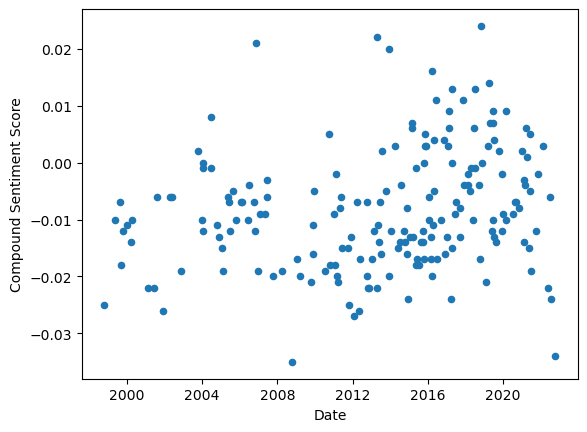

In [14]:
# Set the figure size to make it longer
plt.figure(figsize=(20,4))  # Adjust the values (width, height) as needed

# Create a line plot
df_uk.plot(x='date', y='Compound_sentiment', kind='scatter', marker='o')

# Add a title and labels 
plt.xlabel('Date')
plt.ylabel('Compound Sentiment Score')

# Display the plot
plt.show()

In [58]:
df_uk['Compound_confidence'] = round((df_uk['Lit_count']-df_uk['Uncer_count']) /df_uk['Word_Count'], 3)


<Figure size 2000x400 with 0 Axes>

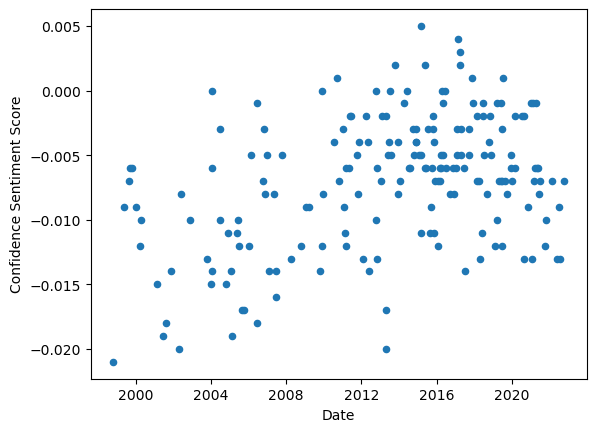

In [59]:
plt.figure(figsize=(20,4))  # Adjust the values (width, height) as needed

# Create a line plot
df_uk.plot(x='date', y='Compound_confidence', kind='scatter', marker='o')

# Add a title and labels 
plt.xlabel('Date')
plt.ylabel('Confidence Sentiment Score')

# Display the plot
plt.show()

<Figure size 2000x400 with 0 Axes>

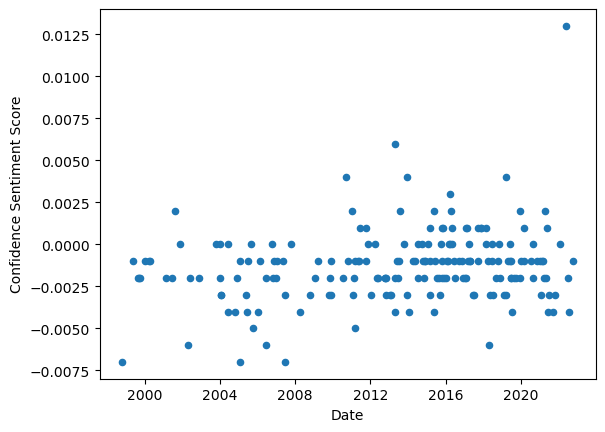

In [60]:
df_uk['Compound_Intensity'] = round((df_uk['Str_count']-df_uk['Weak_count']) /df_uk['Word_Count'], 3)


plt.figure(figsize=(20,4))  # Adjust the values (width, height) as needed

# Create a line plot
df_uk.plot(x='date', y='Compound_Intensity', kind='scatter', marker='o')

# Add a title and labels 
plt.xlabel('Date')
plt.ylabel('Confidence Sentiment Score')

# Display the plot
plt.show()

In [61]:
df_uk.head()

,country,date,title,text,len,text_tokens,text_tokens_no_stopwords,Word_Count,Neg_count,Pos_count,Uncer_count,Lit_count,Str_count,Weak_count,Compound_sentiment,Compound_confidence,Compound_Intensity
0,united kingdom,1998-10-21,Impact of the recent turbulence in internation...,few industries have suffered more from volatil...,13678,"[few, industries, have, suffered, more, from, ...","[industries, suffered, volatility, british, ec...",1183,44,14,27,2,3,11,-0.025,-0.021,-0.007
1,united kingdom,1999-05-17,MPC Two Years On,present at the creation two years ago when it ...,35858,"[present, at, the, creation, two, years, ago, ...","[present, creation, two, years, ago, announced...",3053,65,35,37,9,5,8,-0.010,-0.009,-0.001
2,united kingdom,1999-08-27,Challenges for Monetary Policy: New and Old,the turn of the millennium seems an appropriat...,77081,"[the, turn, of, the, millennium, seems, an, ap...","[turn, millennium, seems, appropriate, moment,...",6904,106,57,60,13,5,17,-0.007,-0.007,-0.002
3,united kingdom,1999-09-09,Reforming the International Financial System: ...,one of the roles which international financial...,35518,"[one, of, the, roles, which, international, fi...","[one, roles, international, financial, officia...",3094,92,35,34,14,6,11,-0.018,-0.006,-0.002
4,united kingdom,1999-10-11,Interest Rates and the UK Economy,twelve months or so ago interest rates were 7 ...,21325,"[twelve, months, or, so, ago, interest, rates,...","[twelve, months, ago, interest, rates, twelve,...",1858,51,29,19,7,6,9,-0.012,-0.006,-0.002


In [62]:
output = pd.DataFrame(df_uk)

# Save the DataFrame to a CSV file
df_uk.to_csv('Wordlist_Sen_analysis.csv', index=False)

## GDP Calculation ##

In [63]:
df_GDP = pd.read_csv('gdp_quarter_on_quarter_growth.csv')
df_GDP['year'] = df_GDP['year'].astype(int)

df_GDP.head()

,year,quarter,value_percentage
0,1955,Q2,0.0
1,1955,Q3,2.0
2,1955,Q4,-0.5
3,1956,Q1,1.1
4,1956,Q2,-0.1


In [66]:
#

# Define the start and end years
start_year = 1998
end_year = 2023

# Filter rows within the time frame
df_GDP = df_GDP[(df_GDP['year'] >= start_year) & (df_GDP['year'] <= end_year)]


df_GDP.head()

,year,quarter,value_percentage
171,1998,Q1,0.7
172,1998,Q2,0.6
173,1998,Q3,0.3
174,1998,Q4,0.7
175,1999,Q1,0.7


In [82]:
# Combining year and quarter into 

# Define a mapping of quarters to month offsets
quarter_to_month = {'Q1': 2, 'Q2': 5, 'Q3': 8, 'Q4': 11}

df_GDP['Quarterly'] = df_GDP.apply(lambda row: pd.to_datetime(str(row['year']) + '-' + str(quarter_to_month[row['quarter']]), format='%Y-%m'), axis=1)

# Reordering the dataframe
new_column_order = ['year', 'quarter', 'Quarterly', 'value_percentage']

df_GDP = df_GDP[new_column_order]

df_GDP.head()

,year,quarter,Quarterly,value_percentage
171,1998,Q1,1998-02-01,0.7
172,1998,Q2,1998-05-01,0.6
173,1998,Q3,1998-08-01,0.3
174,1998,Q4,1998-11-01,0.7
175,1999,Q1,1999-02-01,0.7


<Figure size 2000x400 with 0 Axes>

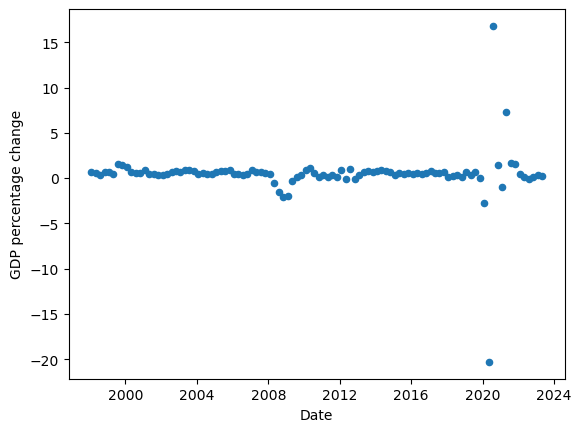

In [83]:
plt.figure(figsize=(20,4))  # Adjust the values (width, height) as needed

# Create a line plot
df_GDP.plot(x='Quarterly', y='value_percentage', kind='scatter', marker='o')

# Add a title and labels 
plt.xlabel('Date')
plt.ylabel('GDP percentage change')

# Display the plot
plt.show()

In [86]:
# Looking at the date bettwen 1998 to 2008
# Define the start and end years
start_year = 1998
end_year = 2008

# Filter rows within the time frame
df_GDP_1 = df_GDP[(df_GDP['year'] >= start_year) & (df_GDP['year'] <= end_year)]


start_date_1 = '1998-01-01'
end_date_1 = '2009-01-01'

df_uk_1 = df_uk[(df_uk['date'] >= start_date_1) & (df_uk['date'] <= end_date_1)]

df_uk_1.tail()

,country,date,title,text,len,text_tokens,text_tokens_no_stopwords,Word_Count,Neg_count,Pos_count,Uncer_count,Lit_count,Str_count,Weak_count,Compound_sentiment,Compound_confidence,Compound_Intensity
41,united kingdom,2007-06-11,Speech,two years ago i spent a few days walking along...,13700,"[two, years, ago, i, spent, a, few, days, walk...","[two, years, ago, spent, days, walking, along,...",1174,24,20,20,3,3,7,-0.003,-0.014,-0.003
42,united kingdom,2007-06-20,Mansion House Dinner,chancellor this will be your last mansion hous...,11720,"[chancellor, this, will, be, your, last, mansi...","[chancellor, last, mansion, house, dinner, mer...",1004,27,21,21,5,2,9,-0.006,-0.016,-0.007
43,united kingdom,2007-10-09,Speech,three weeks ago thousands of depositors queued...,18875,"[three, weeks, ago, thousands, of, depositors,...","[three, weeks, ago, thousands, depositors, que...",1639,59,27,17,9,4,4,-0.020,-0.005,0.000
44,united kingdom,2008-03-31,"Extract from a speech to the Bank of Israel, J...",extract from a speech to the bank of israel je...,8641,"[extract, from, a, speech, to, the, bank, of, ...","[extract, speech, bank, israel, jerusalem, cen...",741,23,9,14,4,4,7,-0.019,-0.013,-0.004
45,united kingdom,2008-10-21,Speech,my first memories of leeds are from a wet summ...,17004,"[my, first, memories, of, leeds, are, from, a,...","[first, memories, leeds, wet, summer, ten, yea...",1489,61,9,20,2,4,8,-0.035,-0.012,-0.003


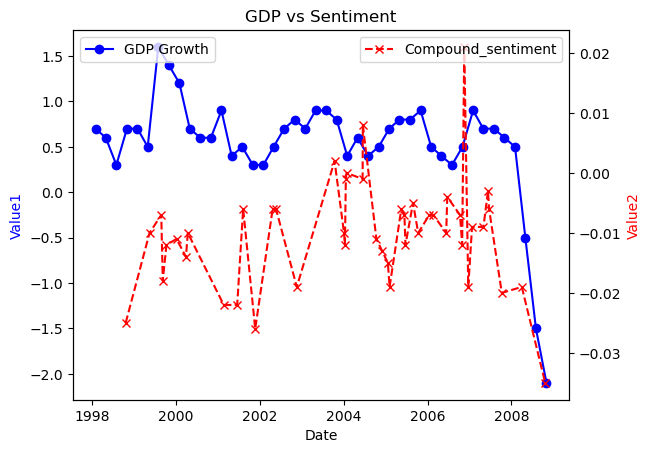

In [116]:
## GDP vs Sentiment for 1998 - 2008
# Create a figure and axis
fig, ax1 = plt.subplots()

# Plot the first time series from df1 on the primary Y-axis (ax1)
ax1.plot(df_GDP_1['Quarterly'], df_GDP_1['value_percentage'], label='GDP Growth', color='b', linestyle='-', marker='o')
ax1.set_xlabel('Date')
ax1.set_ylabel('Value1', color='b')

# Create a secondary Y-axis (ax2)
ax2 = ax1.twinx()

# Plot the second time series from df2 on the secondary Y-axis (ax2)
ax2.plot(df_uk_1['date'], df_uk_1['Compound_sentiment'], label='Compound_sentiment', color='r', linestyle='--', marker='x')
ax2.set_ylabel('Value2', color='r')

# Add labels, legends, and title
ax1.set_title('GDP vs Sentiment')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Display the plot

In [91]:
# Looking at the date bettwen 2009 to 2018
# Define the start and end years
start_year = 2009
end_year = 2018

# Filter rows within the time frame
df_GDP_2 = df_GDP[(df_GDP['year'] >= start_year) & (df_GDP['year'] <= end_year)]


start_date_2 = '2009-01-01'
end_date_2 = '2019-01-01'

df_uk_2 = df_uk[(df_uk['date'] >= start_date_2) & (df_uk['date'] <= end_date_2)]

df_uk_2.tail()

,country,date,title,text,len,text_tokens,text_tokens_no_stopwords,Word_Count,Neg_count,Pos_count,Uncer_count,Lit_count,Str_count,Weak_count,Compound_sentiment,Compound_confidence,Compound_Intensity
147,united kingdom,2018-07-05,From protectionism to prosperity,it is a great pleasure to join the great exhib...,23871,"[it, is, a, great, pleasure, to, join, the, gr...","[great, pleasure, join, great, exhibition, nor...",2148,40,38,18,7,2,8,-0.001,-0.005,-0.003
148,united kingdom,2018-09-14,The future of work,it is a pleasure to deliver this lecture in ho...,26927,"[it, is, a, pleasure, to, deliver, this, lectu...","[pleasure, deliver, lecture, honour, tk, whita...",2379,47,38,22,3,4,8,-0.004,-0.008,-0.002
149,united kingdom,2018-10-19,True Finance,last week global financial policymakers gather...,30456,"[last, week, global, financial, policymakers, ...","[last, week, global, financial, policymakers, ...",2717,92,45,26,15,5,9,-0.017,-0.004,-0.001
150,united kingdom,2018-11-02,£50 character selection and Future Forum launch,it is always a pleasure to visit the science m...,11104,"[it, is, always, a, pleasure, to, visit, the, ...","[always, pleasure, visit, science, museum, gal...",983,9,33,6,4,3,3,0.024,-0.002,0.000
151,united kingdom,2018-11-21,Remarks at the Accounting for Sustainability S...,i would like to thank his royal highness the p...,15049,"[i, would, like, to, thank, his, royal, highne...","[would, like, thank, royal, highness, prince, ...",1302,27,27,11,4,4,6,0.000,-0.005,-0.002


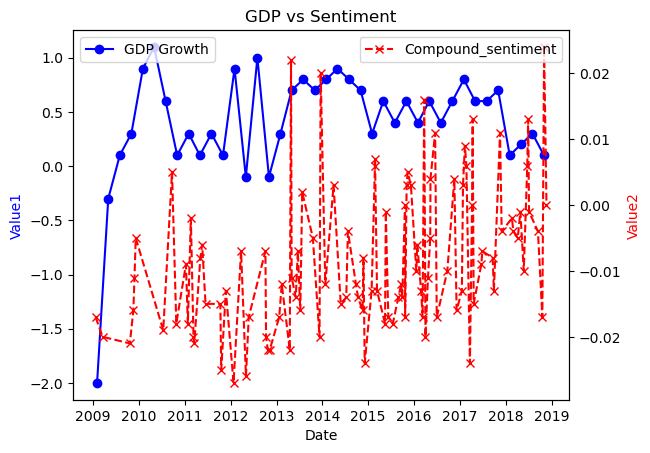

In [117]:
## GDP vs Sentiment for 2009 - 2018
# Create a figure and axis
fig, ax1 = plt.subplots()

# Plot the first time series from df1 on the primary Y-axis (ax1)
ax1.plot(df_GDP_2['Quarterly'], df_GDP_2['value_percentage'], label='GDP Growth', color='b', linestyle='-', marker='o')
ax1.set_xlabel('Date')
ax1.set_ylabel('Value1', color='b')

# Create a secondary Y-axis (ax2)
ax2 = ax1.twinx()

# Plot the second time series from df2 on the secondary Y-axis (ax2)
ax2.plot(df_uk_2['date'], df_uk_2['Compound_sentiment'], label='Compound_sentiment', color='r', linestyle='--', marker='x')
ax2.set_ylabel('Value2', color='r')

# Add labels, legends, and title
ax1.set_title('GDP vs Sentiment')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Display the plot

## Inflation Calculation


In [118]:
df_inf = pd.read_csv('Consumer price inflation time series_inflation.csv')
df_inf = df_inf.rename(columns={'Title': 'Year_date', 'CPI ANNUAL RATE 00: ALL ITEMS 2015=100': 'Inflation Rate'})

top_rows_to_remove = 41
bottom_rows_to_remove = 417

# Remove the top and bottom rows
df_inf = df_inf.iloc[top_rows_to_remove:-bottom_rows_to_remove]
df_inf.tail()

,Year_date,Inflation Rate
175,2022 Q3,10
176,2022 Q4,10.7
177,2023 Q1,10.2
178,2023 Q2,8.4
179,2023 Q3,6.7


In [119]:
df_inf['Inflation Rate'] = pd.to_numeric(df_inf['Inflation Rate'], errors='coerce')
df_inf.head()

,Year_date,Inflation Rate
41,1989 Q1,5.0
42,1989 Q2,5.3
43,1989 Q3,5.1
44,1989 Q4,5.5
45,1990 Q1,5.8


In [120]:
df_inf[['Year', 'Quarter']] = df_inf['Year_date'].str.split(' ', expand=True)

# Create a mapping of quarter names to month numbers
quarter_to_month = {'Q1': 2, 'Q2': 5, 'Q3': 8, 'Q4': 11}

# Map the quarter names to month numbers
df_inf['Month'] = df_inf['Quarter'].map(quarter_to_month)

# Create a datetime column representing the first day of each quarter
df_inf['Date'] = pd.to_datetime(df_inf['Year'] + df_inf['Month'].astype(str).str.zfill(2) + '01', format='%Y%m%d')

# Drop the intermediate columns if not needed
df_inf.drop(['Year', 'Quarter', 'Month','Year_date'], axis=1, inplace=True)

new_column_order = ['Date', 'Inflation Rate']

df_inf = df_inf[new_column_order]


In [121]:
df_inf.head()

,Date,Inflation Rate
41,1989-02-01,5.0
42,1989-05-01,5.3
43,1989-08-01,5.1
44,1989-11-01,5.5
45,1990-02-01,5.8


<Figure size 2000x400 with 0 Axes>

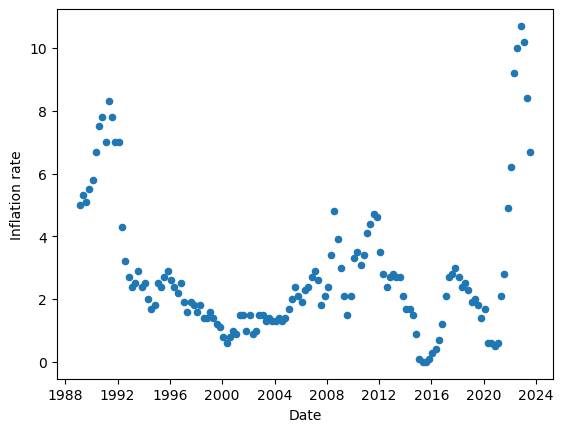

In [122]:
plt.figure(figsize=(20,4))  # Adjust the values (width, height) as needed

# Create a line plot
df_inf.plot(x='Date', y='Inflation Rate', kind='scatter', marker='o')

# Add a title and labels 
plt.xlabel('Date')
plt.ylabel('Inflation rate')

# Display the plot
plt.show()

In [129]:
# Looking at the date bettwen 2009 to 2018
# Define the start and end years
start_date_1 = '1998-01-01'
end_date_1 = '2009-01-01'


# Filter rows within the time frame
df_inf_1 = df_inf[(df_inf['Date'] >= start_date_1) & (df_inf['Date'] <= end_date_1)]

df_uk_1 = df_uk[(df_uk['date'] >= start_date_1) & (df_uk['date'] <= end_date_1)]

df_uk_1.tail()

,country,date,title,text,len,text_tokens,text_tokens_no_stopwords,Word_Count,Neg_count,Pos_count,Uncer_count,Lit_count,Str_count,Weak_count,Compound_sentiment,Compound_confidence,Compound_Intensity
41,united kingdom,2007-06-11,Speech,two years ago i spent a few days walking along...,13700,"[two, years, ago, i, spent, a, few, days, walk...","[two, years, ago, spent, days, walking, along,...",1174,24,20,20,3,3,7,-0.003,-0.014,-0.003
42,united kingdom,2007-06-20,Mansion House Dinner,chancellor this will be your last mansion hous...,11720,"[chancellor, this, will, be, your, last, mansi...","[chancellor, last, mansion, house, dinner, mer...",1004,27,21,21,5,2,9,-0.006,-0.016,-0.007
43,united kingdom,2007-10-09,Speech,three weeks ago thousands of depositors queued...,18875,"[three, weeks, ago, thousands, of, depositors,...","[three, weeks, ago, thousands, depositors, que...",1639,59,27,17,9,4,4,-0.020,-0.005,0.000
44,united kingdom,2008-03-31,"Extract from a speech to the Bank of Israel, J...",extract from a speech to the bank of israel je...,8641,"[extract, from, a, speech, to, the, bank, of, ...","[extract, speech, bank, israel, jerusalem, cen...",741,23,9,14,4,4,7,-0.019,-0.013,-0.004
45,united kingdom,2008-10-21,Speech,my first memories of leeds are from a wet summ...,17004,"[my, first, memories, of, leeds, are, from, a,...","[first, memories, leeds, wet, summer, ten, yea...",1489,61,9,20,2,4,8,-0.035,-0.012,-0.003


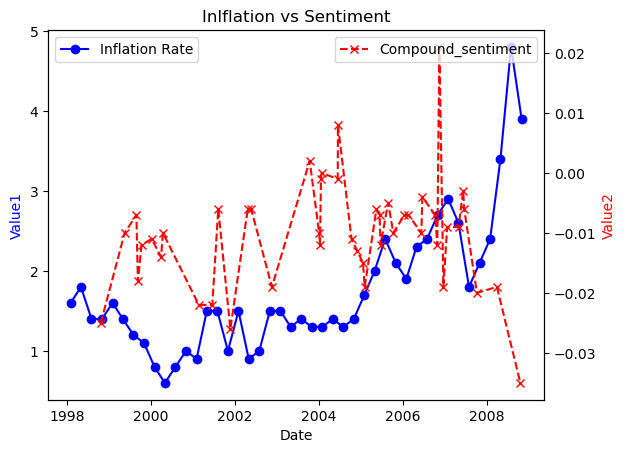

In [130]:
## Inflation vs Sentiment for 1998 - 2008
# Create a figure and axis
fig, ax1 = plt.subplots()

# Plot the first time series from df1 on the primary Y-axis (ax1)
ax1.plot(df_inf_1['Date'], df_inf_1['Inflation Rate'], label='Inflation Rate', color='b', linestyle='-', marker='o')
ax1.set_xlabel('Date')
ax1.set_ylabel('Value1', color='b')

# Create a secondary Y-axis (ax2)
ax2 = ax1.twinx()

# Plot the second time series from df2 on the secondary Y-axis (ax2)
ax2.plot(df_uk_1['date'], df_uk_1['Compound_sentiment'], label='Compound_sentiment', color='r', linestyle='--', marker='x')
ax2.set_ylabel('Value2', color='r')

# Add labels, legends, and title
ax1.set_title('Inlflation vs Sentiment')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Display the plot

In [131]:
start_date_2 = '2000-01-01'
end_date_2 = '2024-01-01'


# Filter rows within the time frame
df_inf_2 = df_inf[(df_inf['Date'] >= start_date_2) & (df_inf['Date'] <= end_date_2)]

df_uk_2 = df_uk[(df_uk['date'] >= start_date_2) & (df_uk['date'] <= end_date_2)]

df_uk_2.tail()

,country,date,title,text,len,text_tokens,text_tokens_no_stopwords,Word_Count,Neg_count,Pos_count,Uncer_count,Lit_count,Str_count,Weak_count,Compound_sentiment,Compound_confidence,Compound_Intensity
185,united kingdom,2022-02-10,A resilient financial system,its a pleasure to be here this evening and let...,8752,"[its, a, pleasure, to, be, here, this, evening...","[pleasure, evening, lets, take, fact, able, po...",736,19,21,9,4,4,4,0.003,-0.007,0.000
186,united kingdom,2022-05-23,Opening remarks at OeNB monetary policy panel,this is a time of very large economic shocks a...,2638,"[this, is, a, time, of, very, large, economic,...","[time, large, economic, shocks, particularly, ...",231,9,4,3,0,3,0,-0.022,-0.013,0.013
187,united kingdom,2022-07-12,"The economic landscape: structural change, glo...",monetary policy must respond to a multitude of...,32705,"[monetary, policy, must, respond, to, a, multi...","[monetary, policy, must, respond, multitude, e...",2837,37,19,30,5,3,9,-0.006,-0.009,-0.002
188,united kingdom,2022-07-19,"Bringing inflation back to the 2% target, no i...",lord mayor it is a great pleasure to be here a...,12120,"[lord, mayor, it, is, a, great, pleasure, to, ...","[lord, mayor, great, pleasure, mansion, house,...",1056,33,8,16,2,2,6,-0.024,-0.013,-0.004
189,united kingdom,2022-10-15,Monetary policy and financial stability interv...,we are meeting in the most difficult of times ...,10270,"[we, are, meeting, in, the, most, difficult, o...","[meeting, difficult, times, saying, start, rec...",879,38,8,8,2,4,5,-0.034,-0.007,-0.001


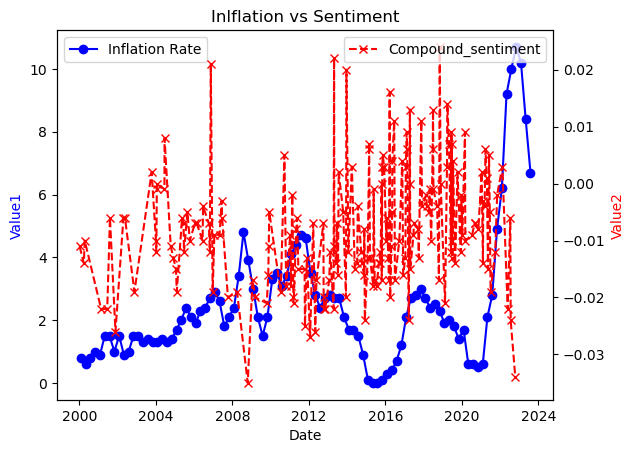

In [132]:
## Inflation vs Sentiment for 2009 - 2018
# Create a figure and axis
fig, ax1 = plt.subplots()

# Plot the first time series from df1 on the primary Y-axis (ax1)
ax1.plot(df_inf_2['Date'], df_inf_2['Inflation Rate'], label='Inflation Rate', color='b', linestyle='-', marker='o')
ax1.set_xlabel('Date')
ax1.set_ylabel('Value1', color='b')

# Create a secondary Y-axis (ax2)
ax2 = ax1.twinx()

# Plot the second time series from df2 on the secondary Y-axis (ax2)
ax2.plot(df_uk_2['date'], df_uk_2['Compound_sentiment'], label='Compound_sentiment', color='r', linestyle='--', marker='x')
ax2.set_ylabel('Value2', color='r')

# Add labels, legends, and title
ax1.set_title('Inlflation vs Sentiment')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Display the plot

## Unemployment Rate

In [156]:
df_un = pd.read_csv('Unemployment_Rate%.csv')
df_un = df_un.rename(columns={'Title': 'Year_date', 'Unemployment rate (aged 16 and over, seasonally adjusted): %': 'Unemployment Rate'})

top_rows_to_remove = 60
bottom_rows_to_remove = 629

# Remove the top and bottom rows
df_un = df_un.iloc[top_rows_to_remove:-bottom_rows_to_remove]
df_un.tail()

,Year_date,Unemployment Rate
264,2022 Q2,3.8
265,2022 Q3,3.6
266,2022 Q4,3.7
267,2023 Q1,3.9
268,2023 Q2,4.2


In [157]:
df_un[['Year', 'Quarter']] = df_un['Year_date'].str.split(' ', expand=True)

# Create a mapping of quarter names to month numbers
quarter_to_month = {'Q1': 2, 'Q2': 5, 'Q3': 8, 'Q4': 11}

# Map the quarter names to month numbers
df_un['Month'] = df_un['Quarter'].map(quarter_to_month)

# Create a datetime column representing the first day of each quarter
df_un['Date'] = pd.to_datetime(df_un['Year'] + df_un['Month'].astype(str).str.zfill(2) + '01', format='%Y%m%d')

# Drop the intermediate columns if not needed
df_un.drop(['Year', 'Quarter', 'Month','Year_date'], axis=1, inplace=True)

new_column_order = ['Date', 'Unemployment Rate']

df_un = df_un[new_column_order].reset_index(drop=True)

df_un.head()

,Date,Unemployment Rate
0,1971-05-01,4.1
1,1971-08-01,4.2
2,1971-11-01,4.4
3,1972-02-01,4.5
4,1972-05-01,4.4


In [158]:
start_date_1 = '2000-01-01'
end_date_1 = '2024-01-01'


# Filter rows within the time frame
df_un_1 = df_un[(df_un['Date'] >= start_date_1) & (df_un['Date'] <= end_date_1)]

df_uk_1 = df_uk[(df_uk['date'] >= start_date_1) & (df_uk['date'] <= end_date_1)]

df_uk_1.tail()

,country,date,title,text,len,text_tokens,text_tokens_no_stopwords,Word_Count,Neg_count,Pos_count,Uncer_count,Lit_count,Str_count,Weak_count,Compound_sentiment,Compound_confidence,Compound_Intensity
185,united kingdom,2022-02-10,A resilient financial system,its a pleasure to be here this evening and let...,8752,"[its, a, pleasure, to, be, here, this, evening...","[pleasure, evening, lets, take, fact, able, po...",736,19,21,9,4,4,4,0.003,-0.007,0.000
186,united kingdom,2022-05-23,Opening remarks at OeNB monetary policy panel,this is a time of very large economic shocks a...,2638,"[this, is, a, time, of, very, large, economic,...","[time, large, economic, shocks, particularly, ...",231,9,4,3,0,3,0,-0.022,-0.013,0.013
187,united kingdom,2022-07-12,"The economic landscape: structural change, glo...",monetary policy must respond to a multitude of...,32705,"[monetary, policy, must, respond, to, a, multi...","[monetary, policy, must, respond, multitude, e...",2837,37,19,30,5,3,9,-0.006,-0.009,-0.002
188,united kingdom,2022-07-19,"Bringing inflation back to the 2% target, no i...",lord mayor it is a great pleasure to be here a...,12120,"[lord, mayor, it, is, a, great, pleasure, to, ...","[lord, mayor, great, pleasure, mansion, house,...",1056,33,8,16,2,2,6,-0.024,-0.013,-0.004
189,united kingdom,2022-10-15,Monetary policy and financial stability interv...,we are meeting in the most difficult of times ...,10270,"[we, are, meeting, in, the, most, difficult, o...","[meeting, difficult, times, saying, start, rec...",879,38,8,8,2,4,5,-0.034,-0.007,-0.001


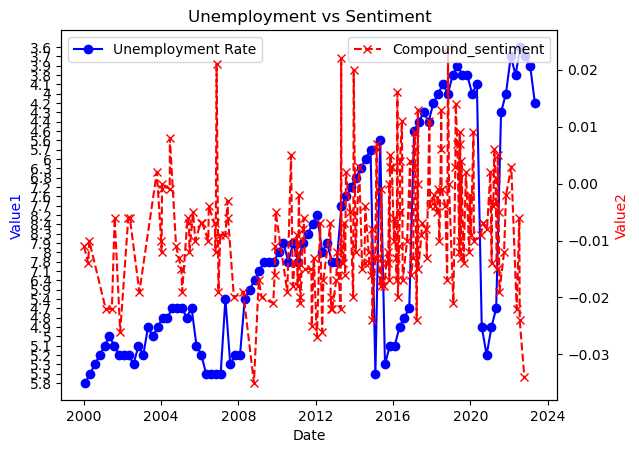

In [188]:
## Unemployment vs Sentiment for 2000 - 2023
# Create a figure and axis
fig, ax1 = plt.subplots()

# Plot the first time series from df1 on the primary Y-axis (ax1)
ax1.plot(df_un_1['Date'], df_un_1['Unemployment Rate'], label='Unemployment Rate', color='b', linestyle='-', marker='o')
ax1.set_xlabel('Date')
ax1.set_ylabel('Value1', color='b')

# Create a secondary Y-axis (ax2)
ax2 = ax1.twinx()

# Plot the second time series from df2 on the secondary Y-axis (ax2)
ax2.plot(df_uk_1['date'], df_uk_1['Compound_sentiment'], label='Compound_sentiment', color='r', linestyle='--', marker='x')
ax2.set_ylabel('Value2', color='r')

# Add labels, legends, and title
ax1.set_title('Unemployment vs Sentiment')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Display the plot

In [189]:
df_exc = pd.read_csv('BoE-Database_export_Daily_Spot exchange rate $ USD into £ Sterling.csv')

df_exc = df_exc.rename(columns={'Date': 'Date', 'Spot exchange rate, US $ into Sterling                          XUDLUSS': 'USD TO GBP'})
df_exc.tail()

,Date,USD TO GBP
6512,08-Jan-98,1.6155
6513,07-Jan-98,1.6242
6514,06-Jan-98,1.6327
6515,05-Jan-98,1.6380
6516,02-Jan-98,1.6405


In [190]:
# Converting Date column into time series
df_exc['Date'] = pd.to_datetime(df_exc['Date'], format='%d-%b-%y')
df_exc.head()

,Date,USD TO GBP
0,2023-10-18,1.2146
1,2023-10-17,1.2182
2,2023-10-16,1.2189
3,2023-10-13,1.2141
4,2023-10-12,1.2214


In [191]:
start_date_1 = '2000-01-01'
end_date_1 = '2024-01-01'


# Filter rows within the time frame
df_exc_1 = df_exc[(df_exc['Date'] >= start_date_1) & (df_exc['Date'] <= end_date_1)]

df_uk_1 = df_uk[(df_uk['date'] >= start_date_1) & (df_uk['date'] <= end_date_1)]


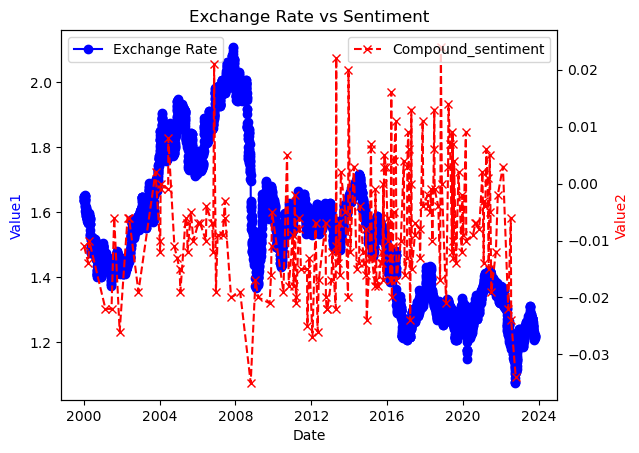

In [192]:
## Exchange Rate vs Sentiment for 2000 - 2023
# Create a figure and axis
fig, ax1 = plt.subplots()

# Plot the first time series from df1 on the primary Y-axis (ax1)
ax1.plot(df_exc_1['Date'], df_exc_1['USD TO GBP'], label='Exchange Rate', color='b', linestyle='-', marker='o')
ax1.set_xlabel('Date')
ax1.set_ylabel('Value1', color='b')

# Create a secondary Y-axis (ax2)
ax2 = ax1.twinx()

# Plot the second time series from df2 on the secondary Y-axis (ax2)
ax2.plot(df_uk_1['date'], df_uk_1['Compound_sentiment'], label='Compound_sentiment', color='r', linestyle='--', marker='x')
ax2.set_ylabel('Value2', color='r')

# Add labels, legends, and title
ax1.set_title('Exchange Rate vs Sentiment')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Display the plot

## Housing Prince Index

In [232]:
df_house = pd.read_csv('ukhpi-united-kingdom-from-1998-01-01-to-2023-12-01.csv')
columns_to_keep = ['Period', 'Percentage change (monthly) All property types']  
df_house = df_house[columns_to_keep] 
df_house = df_house.rename(columns={'Period': 'Date', 'Percentage change (monthly) All property types': 'Monthly Housing price change'})
df_house['Date'] = pd.to_datetime(df_house['Date'] + '-01', format='%Y-%m-%d')
df_house.head()

,Date,Monthly Housing price change
0,1998-01-01,2.52
1,1998-02-01,2.52
2,1998-03-01,2.52
3,1998-04-01,5.32
4,1998-05-01,5.32


In [233]:
start_date_1 = '2000-01-01'
end_date_1 = '2024-01-01'


# Filter rows within the time frame
df_house_1 = df_house[(df_house['Date'] >= start_date_1) & (df_house['Date'] <= end_date_1)]

df_uk_1 = df_uk[(df_uk['date'] >= start_date_1) & (df_uk['date'] <= end_date_1)]


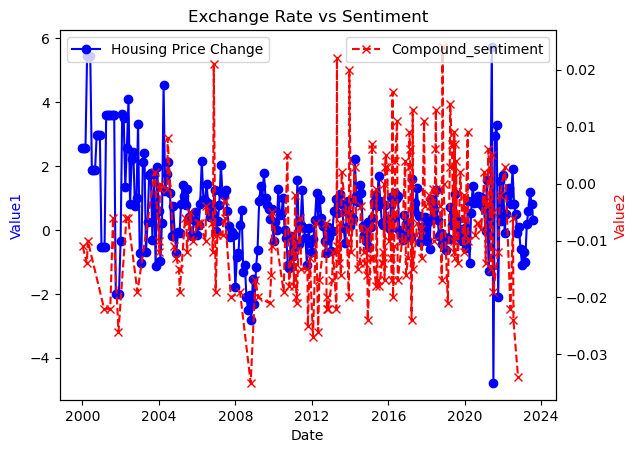

In [234]:
## Housing Price Change vs Sentiment for 2000 - 2023
# Create a figure and axis
fig, ax1 = plt.subplots()

# Plot the first time series from df1 on the primary Y-axis (ax1)
ax1.plot(df_house_1 ['Date'], df_house_1 ['Monthly Housing price change'], label='Housing Price Change', color='b', linestyle='-', marker='o')
ax1.set_xlabel('Date')
ax1.set_ylabel('Value1', color='b')

# Create a secondary Y-axis (ax2)
ax2 = ax1.twinx()

# Plot the second time series from df2 on the secondary Y-axis (ax2)
ax2.plot(df_uk_1['date'], df_uk_1['Compound_sentiment'], label='Compound_sentiment', color='r', linestyle='--', marker='x')
ax2.set_ylabel('Value2', color='r')

# Add labels, legends, and title
ax1.set_title('Exchange Rate vs Sentiment')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Display the plot